# Leveraging Social Media to Identify Major Historic Flood Events, Notebook 2/3: 

## Twitter Data EDA & Analysis

#### Contents

#### Library Import

In [70]:
# Load libraries and functions
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [71]:
# Turn off warnings to reduce angry red-space in notebook
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### EDA

#### Identify city and date range of interest (same as used for corresponding Twitter scrape)

In [72]:
city = 'Houston'
start_date = dt.date(2014, 1, 1)
end_date = dt.date(2018, 1, 1)

In [73]:
# Read .csv created with above parameters
df = pd.read_csv(f'../data/tweetscrape_{city}_{start_date}_to_{end_date}.csv')

In [74]:
# Create df with only columns of interest
tweets = df[['username', 'tweet_id', 'timestamp', 'timestamp_epochs', 'retweets', 'text']]

In [75]:
# How many tweets are we dealing with?
tweets.shape

(33036, 6)

* Houston: 33,036
* Manila: 

In [76]:
# What data-type is our timestamp column?
tweets['timestamp'].dtypes

dtype('O')

#### Timestamp adjustment

##### Remove seconds and convert to date-time

In [77]:
# loop through rows to remove seconds from each timestamp

date_list = []

for tweet in tweets['timestamp']:
    tweet = tweet.replace(' ', '')[:-8] # Remove seconds from the timestamp
    date_list.append(tweet)
    
tweets['clean_date'] = date_list # Save as new column in tweets df

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [78]:
# Change Y-M-D object to datetime format
tweets['clean_date'] = pd.to_datetime(tweets['clean_date'], format='%Y-%m-%d')

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Convert original timestamp to datetime

In [79]:
# Convert original timestamp to datetime to preserve seconds
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

C:\Users\Tilevitz Family\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
# Check all dtypes to make sure everything is as it should be
tweets.dtypes

username                    object
tweet_id                     int64
timestamp           datetime64[ns]
timestamp_epochs             int64
retweets                     int64
text                        object
clean_date          datetime64[ns]
dtype: object

In [81]:
# Check out numeric variables
tweets.describe()

,tweet_id,timestamp_epochs,retweets
count,3.303600e+04,3.303600e+04,33036.000000
mean,8.416015e+17,1.489488e+09,4.245308
std,1.110064e+17,2.646600e+07,79.193981
min,4.338489e+17,1.392273e+09,0.000000
25%,7.861027e+17,1.476256e+09,0.000000
50%,9.023256e+17,1.503966e+09,0.000000
75%,9.032062e+17,1.504176e+09,0.000000
max,9.475989e+17,1.514760e+09,7466.000000


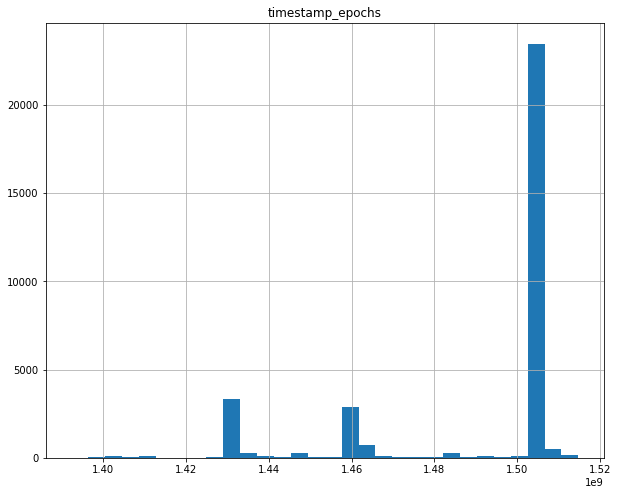

In [82]:
# Check out distribution of tweets using timestamp_epochs
# Which is the numerical representation of time
tweets.hist(column = 'timestamp_epochs', bins = 30, figsize = (10, 8));

**Note:** 
* Houston: 3 major "events" are evident, this will be explored further using timestamps for clarification
* Manila: 

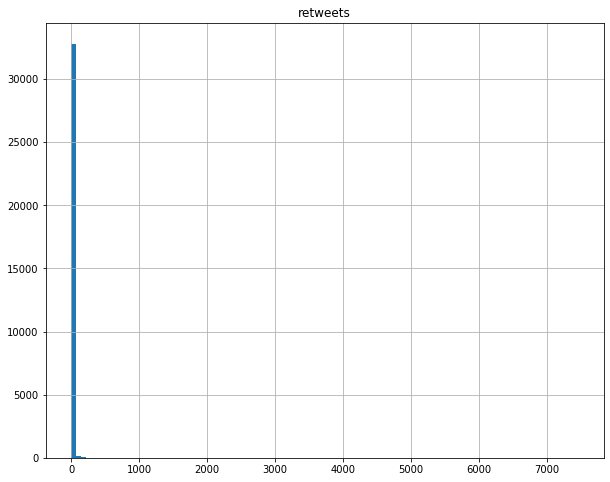

In [83]:
# What does the distribution of retweets look like?
tweets.hist(column = 'retweets', bins = 100, figsize = (10, 8));

**Note:** 
* Houston: This plot does not appear to tell us anything constructive, which was to be expected given the stats in `.describe()`--a mean number of retweets=4.6 with a standard deviation of 84.3 was definitely not normal/horribly skewed.
* Manila: 

#### Identify and drop duplicate tweets

In [84]:
# Identify duplicate tweet content (identical shared newsitems, users with multiple twitter accounts, etc)
tweets[tweets.duplicated(['text'])]

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date
20,mark_tarello,471077480262930432,2014-05-26 23:56:38,1401148598,1,FLOODING from heavy rain this afternoon near H...,2014-05-26
21,Djtexasoutlaw,471074963911213056,2014-05-26 23:46:38,1401147998,0,Flood on di main road! #Houston #Flood http://...,2014-05-26
22,laurenalexxis,471067687708143616,2014-05-26 23:17:43,1401146263,0,Stay safe! #rain #flood #storm #houston #sugar...,2014-05-26
23,leenstaraileen,471067572490616832,2014-05-26 23:17:15,1401146235,0,My daughters boat is floating... #houston #flo...,2014-05-26
24,ImJohnsirz,471066240975654912,2014-05-26 23:11:58,1401145918,0,Welp we lost power her at walgreens. Gonna hav...,2014-05-26
...,...,...,...,...,...,...,...
32868,Texas_Sugar,901313561640787968,2017-08-26 05:21:13,1503724873,0,#Houston Family's system to protect home from ...,2017-08-26
32869,TheSafetyMaster,901313526085677056,2017-08-26 05:21:04,1503724864,0,#Houston Family's system to protect home from ...,2017-08-26
32871,JGiannangelo,901313454140796928,2017-08-26 05:20:47,1503724847,0,#Houston Family's system to protect home from ...,2017-08-26
32872,JadieGirl77479,901313416035545088,2017-08-26 05:20:38,1503724838,0,#Houston Family's system to protect home from ...,2017-08-26


In [85]:
# Drop duplicate tweets
tweets = tweets.drop_duplicates(['text'])

In [86]:
# How many tweets remaining?
tweets.shape

(28139, 7)

**Tweets remaining for further analysis:** <br>

* Houston: 28,139 <br>
* Manila: 

In [87]:
# How many unique timestamps once duplicates are dropped?
tweets['timestamp'].nunique()

26738

**Note:** As all timestamps are not unique, our data cannot be treated as an ideal timeseries/our tweets cannot be indexed by timestamp.
* Houston: 26,738
* Manila: 

In [88]:
# How many posts with >50 retweets?
tweets[tweets['retweets'] > 50].shape

(296, 7)

* Houston: 296 (<1%)
* Manila: 

### Evaluation of flood events by tweet frequency

In [89]:
# Thus our clean_date becomes the index for our data...
daily_tweets = tweets.groupby(tweets['clean_date'])[['text']].count()

In [90]:
tweets['year'] = tweets['clean_date'].dt.year
tweets['month'] = tweets['clean_date'].dt.month

In [91]:
#test = tweets.groupby([tweets["year"], tweets["month"]])[['text']].count()

In [92]:
#test.reset_index()

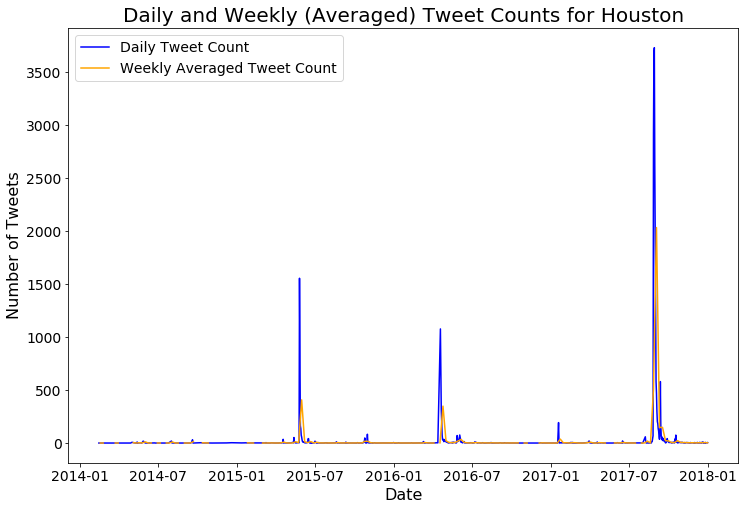

In [93]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Weekly Averaged Tweet Count'], fontsize = 14);
ax.set_title(f'Daily and Weekly (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/dailyct_and_weeklyavg_tweets_{city}.png')

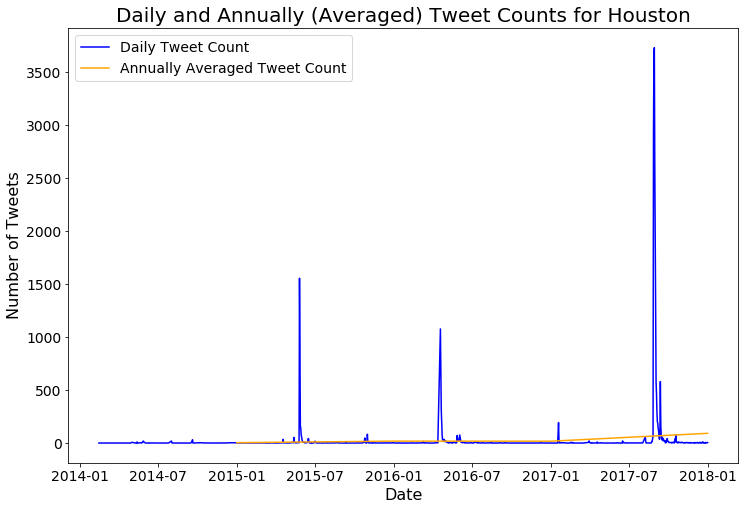

In [94]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], color = 'blue');
ax.plot(daily_tweets['text'].resample('A').mean(), color = 'orange');
ax.legend(['Daily Tweet Count', 'Annually Averaged Tweet Count'], fontsize = 14);
ax.set_title(f'Daily and Annually (Averaged) Tweet Counts for {city}', fontsize = 20)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/dailyct_and_annavg_tweets_{city}.png')

In [95]:
daily_tweets

,text
clean_date,
2014-02-13,1
2014-02-22,1
2014-03-18,1
2014-03-28,1
2014-04-28,1
...,...
2017-12-27,2
2017-12-28,4
2017-12-29,3


In [96]:
# Overall average can be skewed by an anomalous year
daily_tweets['text'].mean()

42.31428571428572

In [97]:
# Get annual averaged numbers of tweets instead
mean_ann_tweets = daily_tweets[['text']].resample('A').mean()

In [98]:
mean_ann_tweets.index = mean_ann_tweets.index.year

In [99]:
daily_tweets

,text
clean_date,
2014-02-13,1
2014-02-22,1
2014-03-18,1
2014-03-28,1
2014-04-28,1
...,...
2017-12-27,2
2017-12-28,4
2017-12-29,3


In [100]:
mean_ann_tweets

,text
clean_date,
2014,4.277778
2015,18.854271
2016,18.186170
2017,92.575893


In [101]:
# Identify all days with tweet counts greater than their respective annual average
bool_list = []
for i in range(len(daily_tweets)):
    bool_list.append(daily_tweets['text'][i] >= mean_ann_tweets.loc[daily_tweets.index[0].year,'text'])
daily_tweets['above_avg'] = bool_list

In [102]:
daily_tweets[daily_tweets['above_avg']==True]

,text,above_avg
clean_date,,
2014-05-01,8,True
2014-05-13,11,True
2014-05-26,12,True
2014-05-27,19,True
2014-05-28,18,True
...,...,...
2017-12-18,9,True
2017-12-19,10,True
2017-12-21,9,True


In [103]:
# Create new dataframe just for days with above average tweet counts
above_avg_tweets = daily_tweets.loc[daily_tweets['above_avg'] == True].drop(columns = 'above_avg')

In [104]:
(above_avg_tweets.resample('W').sum())['text']

clean_date
2014-05-04     8
2014-05-11     0
2014-05-18    11
2014-05-25     0
2014-06-01    58
              ..
2017-12-03     6
2017-12-10     7
2017-12-17    13
2017-12-24    28
2017-12-31    12
Freq: W-SUN, Name: text, Length: 192, dtype: int64

In [105]:
above_avg_tweets

,text
clean_date,
2014-05-01,8
2014-05-13,11
2014-05-26,12
2014-05-27,19
2014-05-28,18
...,...
2017-12-18,9
2017-12-19,10
2017-12-21,9


In [106]:

daily_tweets[daily_tweets['text'] > daily_tweets['text'].mean()]

,text,above_avg
clean_date,,
2015-05-13,53,True
2015-05-26,1556,True
2015-05-27,866,True
2015-05-28,164,True
2015-05-29,137,True
2015-05-30,75,True
2015-05-31,57,True
2015-06-16,43,True
2015-10-25,49,True


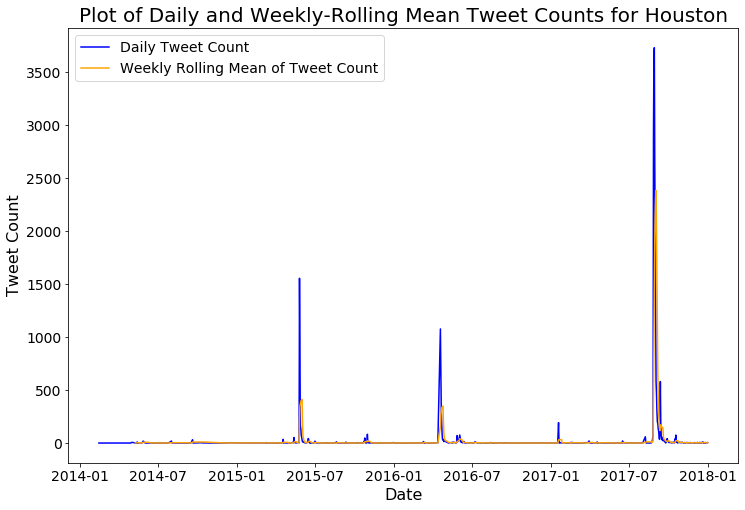

In [107]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(daily_tweets['text'], label = 'Daily Tweet Count', color = 'blue');
ax.plot(daily_tweets['text'].rolling(7).mean(), label = 'Weekly Rolling Mean of Tweet Count', color = 'orange');
ax.set_title(f'Plot of Daily and Weekly-Rolling Mean Tweet Counts for {city}', fontsize = 20);
ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Tweet Count', fontsize = 16);
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize = 14)
plt.savefig(f'../figs/daily_weeklyrollingmean_{city}.png')


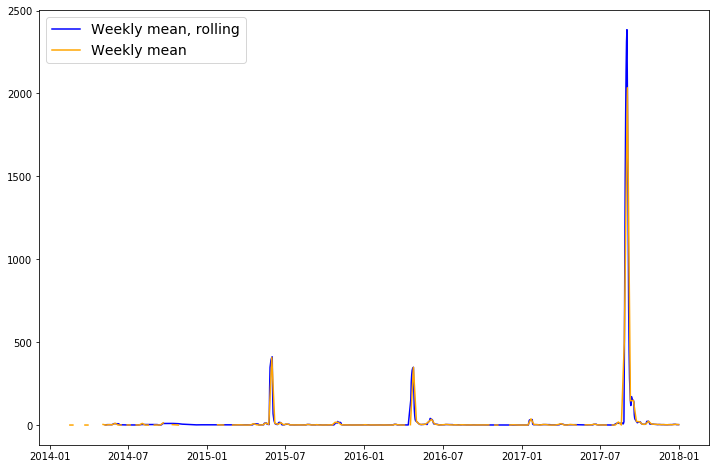

In [108]:
plt.figure(figsize = (12, 8))
plt.plot(daily_tweets['text'].rolling(7).mean(), color = 'blue');
plt.plot(daily_tweets['text'].resample('W').mean(), color = 'orange');
plt.legend(['Weekly mean, rolling', 'Weekly mean'], fontsize = 14);

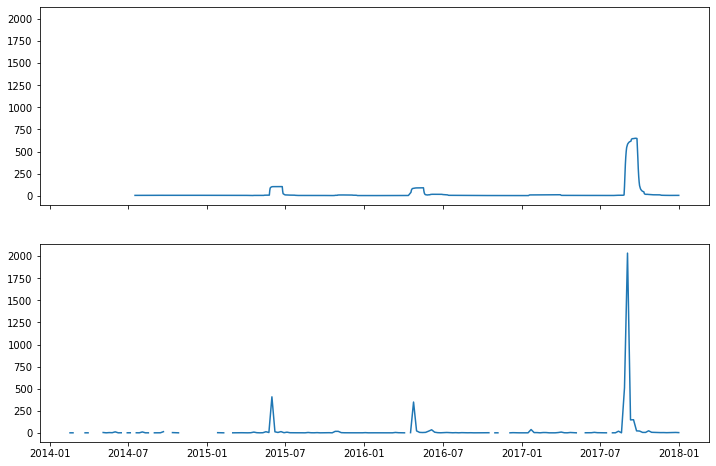

In [109]:
fig,ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8), sharex = True, sharey = True)

ax[0].plot(daily_tweets['text'].rolling(30).mean());
ax[1].plot(daily_tweets['text'].resample('W').mean());

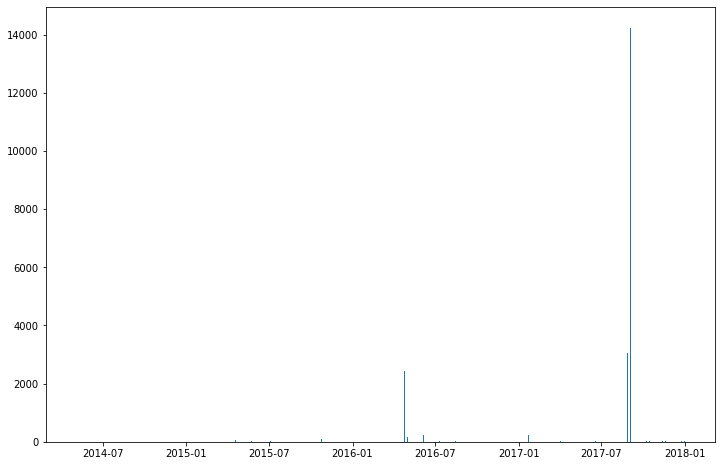

In [110]:
plt.figure(figsize = (12, 8))
plt.bar(above_avg_tweets['text'].resample('W').sum().index, above_avg_tweets['text'].resample('W').sum());

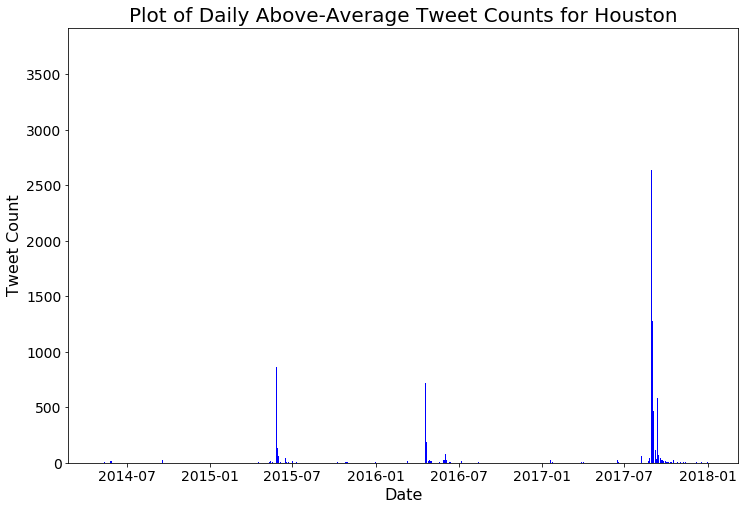

In [111]:
plt.figure(figsize = (12, 8))
plt.bar(above_avg_tweets['text'].index, above_avg_tweets['text'], color = 'blue');
plt.title(f'Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Tweet Count', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/daily_abvavg_{city}.png')

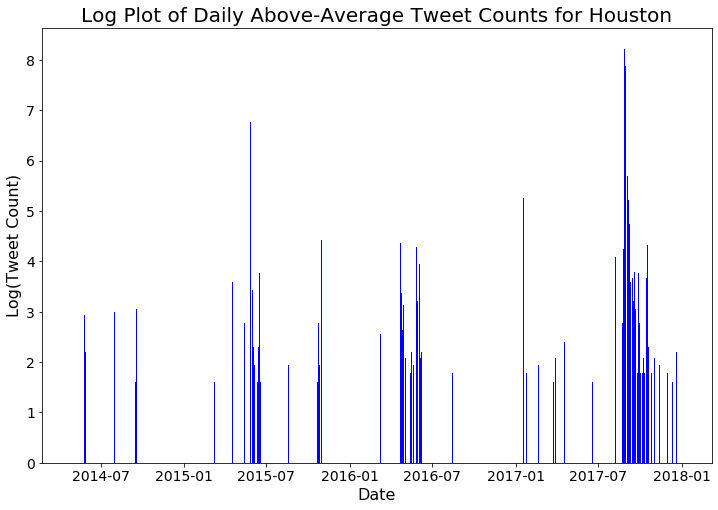

In [112]:
plt.figure(figsize = (12, 8));
plt.bar(above_avg_tweets['text'].index, np.log(above_avg_tweets['text']), color = 'blue');
plt.title(f'Log Plot of Daily Above-Average Tweet Counts for {city}', fontsize = 20);
plt.xlabel('Date', fontsize = 16);
plt.ylabel('Log(Tweet Count)', fontsize = 16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'../figs/log_daily_abvavg_{city}.png')

### CountVectorizer & Show Most Frequent Words

In [113]:
cvec_tw = CountVectorizer()

In [114]:
stopWords = ['com', 'http', 'twitter', 'https', 'pic', 'www', 'ly', 
             'yahoo', 'yhoo', 'youtu', 'youtube', 'fb', 'instagram', 
             'tt', 'html', 'goo', 'gl', 'google'] + list(ENGLISH_STOP_WORDS) 

In [115]:
# Initiate instance of CountVectorizer for tweet data
cvec_tw = CountVectorizer(stop_words = stopWords, # get rid of stopwords, right now we're more interested in what's left after
                          max_features = 500, # only use 500 top features
                          max_df = 0.98)  # Don't use features that appear in more than 98% of entries

# Pull out 'title' column from climatechange data
X_tw = tweets['text']

# Fit the vectorizer to our corpus
cvec_tw.fit(X_tw)

# Transform the training corpus
X_tw = cvec_tw.transform(X_tw)

# Convert result into a dataframe
X_tw_df = pd.DataFrame(X_tw.toarray(),
                          columns=cvec_tw.get_feature_names())
X_tw_df.head()

,000,01,04,05,08,09,10,11,12,12145510,...,weight,west,woman,work,world,wow,wp,ws,year,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [116]:
X_tw_df.shape

(28139, 500)

In [117]:
# Save 20 most frequently appearing words to a df, in descending order
tw_bardat = X_tw_df.sum().sort_values(ascending = False)[0:20].to_frame()

In [118]:
tw_bardat.index

Index(['houston', 'floodwaters', 'harvey', 'flooding', 'flood', 'texas',
       'news', 'status', 'police', 'houstonflood', 'hurricane', '2017',
       'floodwater', 'officer', 'rain', 'rising', 'rescue', 'hurricaneharvey',
       'rise', 'bit'],
      dtype='object')

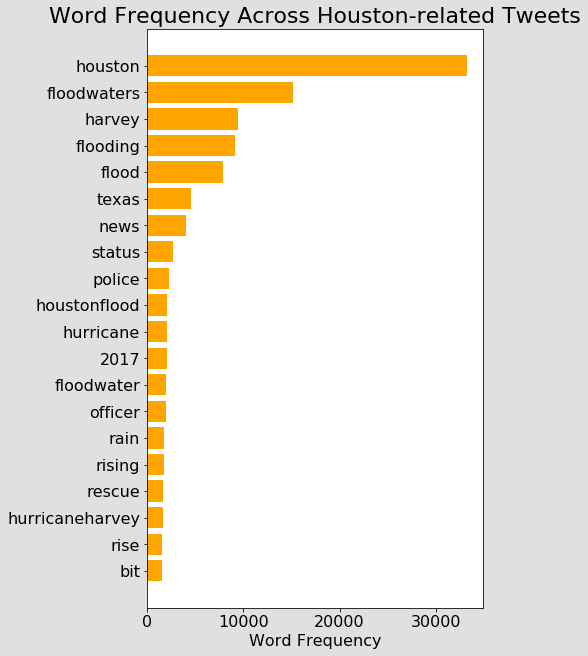

In [119]:
fig, ax = plt.subplots(figsize=(8, 9), sharex = True, constrained_layout = True, # Share x axes to keep ranges the same
                              facecolor = '#E0E0E0')  # Set figure facecolor to match slide theme
ax.barh(tw_bardat.index, tw_bardat[0], color = 'orange');
ax.invert_yaxis(); # Flip plot vertically so values descending from top
ax.set_title(f'Word Frequency Across {city}-related Tweets', fontsize = 22);
ax.set_xlabel('Word Frequency', fontsize = 16);
ax.set_yticklabels(tw_bardat.index, fontsize = 14)
ax.tick_params(labelsize = 16)
         

In [120]:
# For loop to do most of my 'Title' cleaning--remove punctuation, convert to lowercase, lemmatize
# With guidance from Preeya Sawadmanod

text_puncless = []
text_lemmed = []

for row in tweets['text']:
    # Instantiate tokenizer/set to remove punctuation, numbers, and any 'words' comprised of just 1 character
    # Numbers removed because many were completely extraneous
    # And the ones that might have been useful weren't useful enough to justify keeping the rest
    tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') # (r'\w+')

    # Instantiate lemmatizer: lemmatizer over stemmer because false negatives are preferable here to false positives
    # We don't want to over-estimate the accuracy of our predictions
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize each row (also do the change to lower-case here)
    rows = tokenizer.tokenize(row.lower())
    
    # Lemmatize all words in each row
    lem_rows = [lemmatizer.lemmatize(word) for word in rows]
    
    # Change each row back from a list of strings to a single string
    rows = ' '.join(rows)
    lem_rows = ' '.join(lem_rows)
    
    # Append fixed rows to their respective lists
    text_puncless.append(rows)
    text_lemmed.append(lem_rows)

In [121]:
len(text_puncless)

28139

In [122]:
tweets.shape

(28139, 9)

In [123]:
# Insert cleaned lists of titles into dataframe as new columns
tweets['text_nopunc'] = text_puncless
tweets['text_lemmed'] = text_lemmed

In [124]:
tweets.head()

,username,tweet_id,timestamp,timestamp_epochs,retweets,text,clean_date,year,month,text_nopunc,text_lemmed
0,mark_tarello,471077480262930432,2014-05-26 23:56:38,1401148598,1,FLOODING from heavy rain this afternoon near H...,2014-05-26,2014,5,flooding from heavy rain this afternoon near h...,flooding from heavy rain this afternoon near h...
1,Djtexasoutlaw,471074963911213056,2014-05-26 23:46:38,1401147998,0,Flood on di main road! #Houston #Flood http://...,2014-05-26,2014,5,flood on di main road houston flood http insta...,flood on di main road houston flood http insta...
2,laurenalexxis,471067687708143616,2014-05-26 23:17:43,1401146263,0,Stay safe! #rain #flood #storm #houston #sugar...,2014-05-26,2014,5,stay safe rain flood storm houston sugarland h...,stay safe rain flood storm houston sugarland h...
3,leenstaraileen,471067572490616832,2014-05-26 23:17:15,1401146235,0,My daughters boat is floating... #houston #flo...,2014-05-26,2014,5,my daughters boat is floating houston flooding...,my daughter boat is floating houston flooding ...
4,ImJohnsirz,471066240975654912,2014-05-26 23:11:58,1401145918,0,Welp we lost power her at walgreens. Gonna hav...,2014-05-26,2014,5,welp we lost power her at walgreens gonna have...,welp we lost power her at walgreens gonna have...


In [125]:
# WORD-TO-VEC ???? Try kmeans with and without word2vec
# Support vector machines
# KMeans
# Cosine similarity?


In [126]:
X = tweets['text_lemmed']
